In [6]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.impute import SimpleImputer
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import warnings
import csv
warnings.filterwarnings("ignore")

In [59]:
input_l = []
prompts = [
    "Do you have diabeties ?(1 for yes and 0 for No) ",
    "What is the Alcohol Level in your blood? ",
    "Whats your heart rate as of now? ",
    "what was your last measured blood Oxygen Level",
    "What is your body Temperature? ",
    "What is your Weight? ",
    "What was the Delay in Your MRI testing ",
    "Do you take any of the Prescriptions? (Galantamine ,Donepezil ,Memantine ,Rivastigmine ,  Leave blank for None of the Above) ",
    "What is Dosage in mg you take for the drug (Leave blank for none) ",
    "What is your age?",
    "What is your Education Level (Primary School,Secondary School, No School ,Degree) ",
    "What is your dominant Hand (Left and right)",
    "What is your Gender (Male ,Female)",
    "Do you have any Family History with Dimentia (No ,Yes) ",
    "Do you Smoke? (Current Smoker , Former Smoker , Never Smoker) ",
    "APOE_Îµ4 (Positive ,  Negative) ",
    "Physical_Activity (Sedentery , Moderate , Mild) ",
    "Are You Depressed (Yes , No): ",
    "Cognitive_Test_Scores from (10 to 0) ",
    "Do you have any Medication History(Yes or No) ",
    "What Nutrition Diet do you have (Low-Carb Diet, Mediterranean Diet, Balanced Diet)",
    "Sleep Quality (Poor , Good)",
    "Do you have any Chronic Heart Disease (Diabetes,Heart disease,Hypertension,None)",
]
for i in range(0,len(prompts)):
    a = input(prompts[i])
    input_l.append(a)
print(input_l)

    

['1', '0.001', '69', '35.77', '37', '73', '35.5', 'Donepezil', '1.5', '18', 'Degree', 'Left', 'Male', 'No', 'Never Smoker', 'Negative', 'Mild', 'No', '5', 'Yes', 'Balanced Diet', 'Poor', 'Diabetes']


In [67]:
columns_l = ["Diabetic","AlcoholLevel","HeartRate","BloodOxygenLevel","BodyTemperature","Weight","MRI_Delay","Prescription","Dosage in mg","Age","Education_Level","Dominant_Hand","Gender","Family_History","Smoking_Status","APOE_ε4","Physical_Activity","Depression_Status","Cognitive_Test_Scores","Medication_History","Nutrition_Diet","Sleep_Quality","Chronic_Health_Conditions"]
len(columns_l)

23

In [70]:
#hyperparameter
RAND_VAL = 42
num_folds = 2  # Number of folds
n_est = 970  # Increase number of estimators for better performance
df_train = pd.read_csv(r"C:\DataSets\Dementia_Backup.csv")
df_test = pd.DataFrame(input_l)
df_test = df_test.transpose()
df_test.columns = columns_l
df_train.dtypes

Diabetic                       int64
AlcoholLevel                 float64
HeartRate                      int64
BloodOxygenLevel             float64
BodyTemperature              float64
Weight                       float64
MRI_Delay                    float64
Prescription                  object
Dosage in mg                 float64
Age                            int64
Education_Level               object
Dominant_Hand                 object
Gender                        object
Family_History                object
Smoking_Status                object
APOE_ε4                       object
Physical_Activity             object
Depression_Status             object
Cognitive_Test_Scores          int64
Medication_History            object
Nutrition_Diet                object
Sleep_Quality                 object
Chronic_Health_Conditions     object
Dementia                       int64
dtype: object

In [74]:
a = df_train.dtypes.to_dict()
a = {'Diabetic': int, 'AlcoholLevel':float, 'HeartRate': int, 'BloodOxygenLevel': float, 'BodyTemperature': float, 'Weight': float, 'MRI_Delay': float, 'Prescription': object, 'Dosage in mg': float, 'Age': int ,
      'Education_Level': object, 'Dominant_Hand': object, 'Gender':object, 'Family_History': object, 'Smoking_Status': object, 'APOE_ε4': object, 'Physical_Activity': object, 'Depression_Status': object, 'Cognitive_Test_Scores': object, 'Medication_History': object, 'Nutrition_Diet': object, 'Sleep_Quality': object, 'Chronic_Health_Conditions': object}

df_test = df_test.astype(a)
df_test.dtypes

Diabetic                       int32
AlcoholLevel                 float64
HeartRate                      int32
BloodOxygenLevel             float64
BodyTemperature              float64
Weight                       float64
MRI_Delay                    float64
Prescription                  object
Dosage in mg                 float64
Age                            int32
Education_Level               object
Dominant_Hand                 object
Gender                        object
Family_History                object
Smoking_Status                object
APOE_ε4                       object
Physical_Activity             object
Depression_Status             object
Cognitive_Test_Scores         object
Medication_History            object
Nutrition_Diet                object
Sleep_Quality                 object
Chronic_Health_Conditions     object
dtype: object

In [75]:
def impute(df):
    # List of numerical and categorical columns
    numerical_columns = df.select_dtypes(include=['number']).columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Impute missing values with 0 for numerical columns
    numerical_imputer = SimpleImputer(strategy='constant', fill_value=0)
    df[numerical_columns] = numerical_imputer.fit_transform(df[numerical_columns])

    # Impute missing values with '0' for categorical columns
    categorical_imputer = SimpleImputer(strategy='constant', fill_value=0)
    df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])
    return df
df_train = impute(df_train)
# df_test = impute(df_test)


In [76]:
scale_cols = ['AlcoholLevel','BodyTemperature', 'BloodOxygenLevel', 'Weight', 'MRI_Delay']
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)
    
def getFeats(df):
    df.drop(['Dosage in mg','Cognitive_Test_Scores'],axis=1,inplace=True)
    return df

df_train = getFeats(df_train)
df_test = getFeats(df_test)

In [77]:
feat_cols = df_train.columns.drop(['Dementia'])
feat_cols = feat_cols.drop(scale_cols)
X = df_train[feat_cols]
y = df_train['Dementia']

cat_features = np.where(X.dtypes != np.float64)[0]
folds = StratifiedKFold(n_splits=num_folds, random_state=RAND_VAL, shuffle=True)
test_preds = np.zeros((num_folds, len(df_test)))
auc_vals = []

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    clf = CatBoostClassifier(
        eval_metric='AUC',
        learning_rate=0.2,
        iterations=n_est,
        depth=6,    # Increase depth for better complexity
        l2_leaf_reg=3  # Regularization parameter
    )
    clf.fit(train_pool, eval_set=val_pool, verbose=300)

    y_pred_val = clf.predict_proba(X_val[feat_cols])[:, 1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ", n_fold, ": ", auc_val)
    auc_vals.append(auc_val)

    y_pred_test = clf.predict_proba(df_test[feat_cols])[:, 1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

0:	test: 0.9997598	best: 0.9997598 (0)	total: 206ms	remaining: 3m 19s
300:	test: 1.0000000	best: 1.0000000 (1)	total: 12.2s	remaining: 27.1s
600:	test: 1.0000000	best: 1.0000000 (1)	total: 24.2s	remaining: 14.9s
900:	test: 1.0000000	best: 1.0000000 (1)	total: 35.7s	remaining: 2.74s
969:	test: 1.0000000	best: 1.0000000 (1)	total: 38.4s	remaining: 0us

bestTest = 1
bestIteration = 1

Shrink model to first 2 iterations.
AUC for fold  0 :  1.0
----------------
0:	test: 0.9997758	best: 0.9997758 (0)	total: 56.6ms	remaining: 54.9s
300:	test: 1.0000000	best: 1.0000000 (1)	total: 11.7s	remaining: 26.1s
600:	test: 1.0000000	best: 1.0000000 (1)	total: 23.5s	remaining: 14.4s
900:	test: 1.0000000	best: 1.0000000 (1)	total: 35.4s	remaining: 2.71s
969:	test: 1.0000000	best: 1.0000000 (1)	total: 38.1s	remaining: 0us

bestTest = 1
bestIteration = 1

Shrink model to first 2 iterations.
AUC for fold  1 :  1.0
----------------


Mean AUC:  1.0


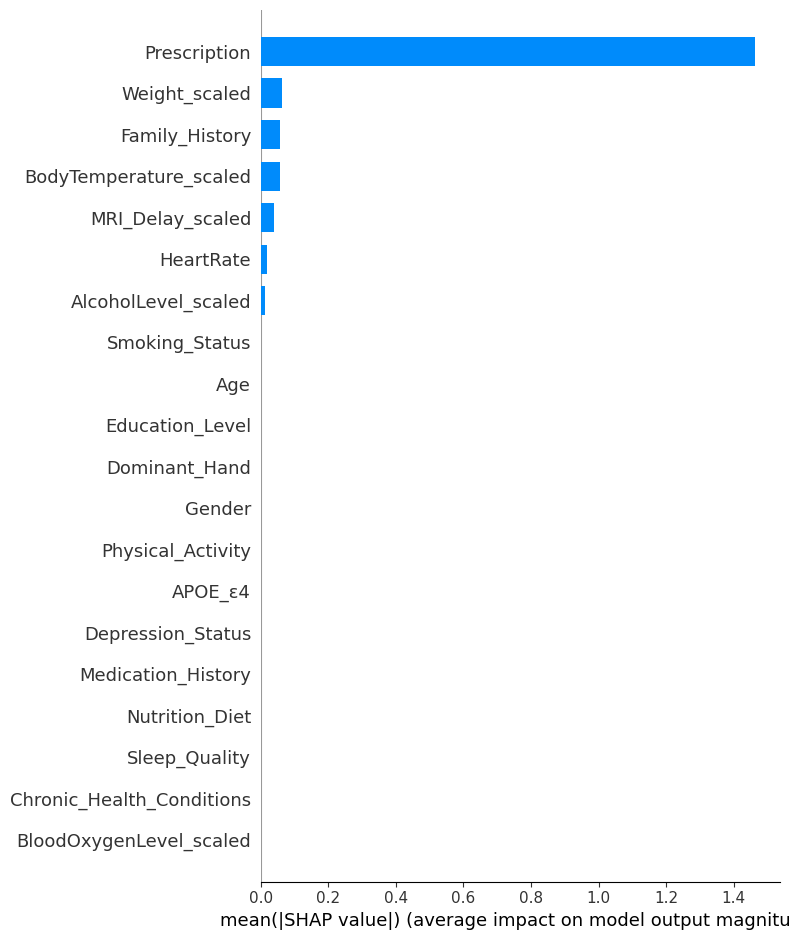

In [78]:
mean_auc = np.mean(auc_vals)
print("Mean AUC: ", mean_auc)

# SHAP analysis
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, X_train, plot_type="bar")


In [79]:
df_test['index'] = range(1, len(df_test) + 1)
y_pred = test_preds.mean(axis=0)
df_sub = df_test[['index']]
df_sub['Dementia'] = y_pred
df_sub.to_csv("submission.csv", index=False)

In [84]:
print(test_preds.mean(axis=0))
if test_preds.mean(axis=0) > 0.5:
    print("You have a ", (test_preds.mean(axis=0) - 0.5)*100 , "% chance of having dementia")

[0.84763045]
You have a  [34.76304486] % chance of having dementia
